In [1]:
%%capture
!pip install fairlearn
!pip install tensorflow-macos 2.9.0 --force-reinstall

!pip install tensorflow-metal 0.5.0 --force-reinstall

In [2]:
#@markdown 
import numpy as np
from IPython.display import display, Markdown, Latex
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.metrics import MetricFrame
import fairlearn.datasets as fdata
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio, 
                               selection_rate_difference, false_negative_rate_difference, 
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

# Load and preprocess the data

In [3]:
#@markdown Load and read about the dataset.
# get datast from fairlearn and show description
dataset = fdata.fetch_diabetes_hospital()

display(Markdown(dataset.DESCR))

# save dataframe and features
x_raw = dataset.data
# y_raw = np.array(dataset.target)
feature_names = dataset.feature_names

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


The "Diabetes 130-Hospitals" dataset represents 10 years of clinical care at 130 U.S. hospitals and delivery networks, collected from 1999 to 2008. Each record represents the hospital admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

The original "Diabetes 130-Hospitals" dataset was collected by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore in 2014.

This version of the dataset was derived by the Fairlearn team for the SciPy 2021 tutorial "Fairness in AI Systems: From social context to practice using Fairlearn". In this version, the target variable "readmitted" is binarized into whether the patient was re-admitted within thirty days. The full dataset pre-processing script can be found on GitHub: https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/preprocess.py

Downloaded from openml.org.

You can read more about the dataset [here](https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html). In this description, we see that two features, `readmitted` and `readmit_binary`, are other representations of the same outcome, so we drop them from the set of predictors.

In [4]:
#@markdown Down sample to make runtimes reasonable
x_raw = x_raw.sample(frac=0.1, random_state=123)

In [5]:
y_raw = x_raw['readmit_binary']
x_raw = x_raw.drop(columns=['readmitted', 'readmit_binary'])
feature_names = feature_names[:-2]

In [6]:
#@markdown Look at the first few rows of the data.
x_raw.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum,A1Cresult,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days
65884,Caucasian,Male,Over 60 years,Discharged to Home,Emergency,3,Missing,49,6,27,...,None,None,Up,Ch,Yes,False,False,False,True,False
86278,Caucasian,Female,Over 60 years,Other,Referral,5,Missing,57,0,21,...,None,None,No,Ch,Yes,True,False,False,True,False
30000,Caucasian,Male,30-60 years,Discharged to Home,Other,4,Other,37,2,9,...,None,None,No,No,No,False,False,False,False,False
51185,Caucasian,Male,30-60 years,Other,Other,9,InternalMedicine,61,6,27,...,None,>8,No,Ch,Yes,False,False,True,False,True
53902,Caucasian,Female,30-60 years,Discharged to Home,Referral,7,Other,23,0,13,...,None,None,No,No,Yes,True,False,True,True,False


## data inspectation 

In [7]:
#@markdown drop the rows with 'Unknown/Invalid' values for gender

# drop these 3 rows
print(x_raw.shape)
rows_to_keep = x_raw.gender != 'Unknown/Invalid'
x_raw = x_raw[rows_to_keep]
y_raw = y_raw[rows_to_keep]
print(x_raw.shape)

(10177, 22)
(10177, 22)


In [8]:
#@markdown
unique_feature_values = x_raw.apply(np.unique, axis=0)
unique_feature_values

race                        [AfricanAmerican, Asian, Caucasian, Hispanic, ...
gender                                                         [Female, Male]
age                         [30 years or younger, 30-60 years, Over 60 years]
discharge_disposition_id                          [Discharged to Home, Other]
admission_source_id                              [Emergency, Other, Referral]
time_in_hospital              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
medical_specialty           [Cardiology, Emergency/Trauma, Family/GeneralP...
num_lab_procedures          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
num_procedures                                          [0, 1, 2, 3, 4, 5, 6]
num_medications             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
primary_diagnosis           [Diabetes, Genitourinary Issues, Musculoskelet...
number_diagnoses                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 16]
max_glu_serum                                        [>200, >300

In [9]:
#@markdown
binary_features = unique_feature_values.index[[len(x) == 2 for x in unique_feature_values]].values
print(f'Binary features: {binary_features}')
categorical_features = unique_feature_values.index[[len(x) > 2 and isinstance(x[0], str) for x in unique_feature_values]].values
print(f'Categorical features: {categorical_features}')

Binary features: ['gender' 'discharge_disposition_id' 'change' 'diabetesMed' 'medicare'
 'medicaid' 'had_emergency' 'had_inpatient_days' 'had_outpatient_days']
Categorical features: ['race' 'age' 'admission_source_id' 'medical_specialty'
 'primary_diagnosis' 'max_glu_serum' 'A1Cresult' 'insulin']


In [10]:
#@markdown standardize data types 
for col_name in feature_names:
    if col_name in categorical_features:
        x_raw[col_name] = x_raw[col_name].astype('category')
    elif col_name in binary_features:  # redundant for clarity
        # turn into int column
        integer_col = (x_raw[col_name] == unique_feature_values[col_name][0]).astype(int)
        new_name = f'{col_name}_{unique_feature_values[col_name][0]}'
        x_raw[new_name] = integer_col
        x_raw.drop(columns=[col_name], inplace=True) 

In [11]:
#@markdown
%%capture
x_raw.apply(np.unique, axis=0)

In [12]:
x_raw.dtypes

race                                           category
age                                            category
admission_source_id                            category
time_in_hospital                                  int64
medical_specialty                              category
num_lab_procedures                                int64
num_procedures                                    int64
num_medications                                   int64
primary_diagnosis                              category
number_diagnoses                                  int64
max_glu_serum                                  category
A1Cresult                                      category
insulin                                        category
gender_Female                                     int64
discharge_disposition_id_Discharged to Home       int64
change_Ch                                         int64
diabetesMed_No                                    int64
medicare_False                                  

In [13]:
#@markdown One-hot encode categorical features
x_numeric = pd.get_dummies(x_raw)
display(x_numeric.head())

# get one-hot and numeric column names
numeric_cols = x_numeric.dtypes.index[x_numeric.dtypes == 'int64'].values
one_hot_cols = x_numeric.dtypes.index[x_numeric.dtypes != 'int64'].values

#x_numeric.dtypes

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,gender_Female,discharge_disposition_id_Discharged to Home,change_Ch,diabetesMed_No,medicare_False,...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
65884,3,49,6,27,9,0,1,1,0,1,...,1,0,0,0,1,0,0,0,0,1
86278,5,57,0,21,9,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
30000,4,37,2,9,5,0,1,0,1,1,...,1,0,0,0,1,0,0,1,0,0
51185,9,61,6,27,9,0,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0
53902,7,23,0,13,7,1,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0


 # TODO: Split train, test data 80 train / 20 test 


In [14]:
# write your code here 
#here we are setting a value for the random_state (seed) parameter so that the results of this lab will remain consistent

X_train, X_test, y_train, y_test = train_test_split(x_numeric, y_raw, test_size=0.2, random_state=4)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train.head(5)

X_train shape: (8141, 49)
y_train shape: (8141,)
X_test shape: (2036, 49)
y_test shape: (2036,)


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,gender_Female,discharge_disposition_id_Discharged to Home,change_Ch,diabetesMed_No,medicare_False,...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
55665,1,36,6,12,9,1,1,1,0,1,...,1,0,0,0,1,0,0,0,0,1
10284,4,62,6,14,6,1,0,0,1,1,...,1,0,0,0,1,0,0,1,0,0
47592,4,43,1,11,9,1,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
21033,8,80,6,33,9,0,1,1,0,1,...,1,0,0,1,0,0,1,0,0,0
64840,14,75,6,29,9,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1


# Problem 2, Part (a) 
### **Train a baseline Random Forest (RF) (sklearn RandomForestClassifier) model and report metrics**

### Train a random forest model - Baseline

In [15]:
# write your code here 
# initialize a model with RandomForestClassifier 
n_estimators = 1

rf_model = RandomForestClassifier(n_estimators=1, random_state=4)
# train the model with the training data split
rf_model.fit(X_train, y_train)

# a simple Evaluate model on test set
accuracy = rf_model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5162082514734774


### Report metrics

Calculate metrics with Fairlearn MetricFrame


In [39]:
# write your code here 
# demographic_parity_difference, demographic_parity_ratio, 
#                                selection_rate_difference, false_negative_rate_difference, 
#                                false_positive_rate_difference, equalized_odds_ratio,
#                                false_negative_rate, false_positive_rate)
# get model's prediction for the test set
y_pred_baseline = rf_model.predict(X_test)
sensitive_f = X_test['gender_Female'].replace({1:'female', 0:'male'})

# get the overall metrics

# use MetricFrame to get the results 

metric_dict = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'FNR': false_negative_rate,
        'FPR': false_positive_rate,
        'fnr_diff': false_negative_rate_difference,
        'fpr_diff':false_positive_rate_difference,
        'demographic_parity_ratio': demographic_parity_ratio,
        'equalized_odds_ratio': equalized_odds_ratio,
        'selection_rate_diff': selection_rate_difference

        }

sample_p = {
        'fnr_diff': {'sensitive_features': sensitive_f},
        'fpr_diff': {'sensitive_features': sensitive_f},
        'demographic_parity_ratio': {'sensitive_features': sensitive_f},
        'equalized_odds_ratio': {'sensitive_features': sensitive_f},
        'selection_rate_diff': {'sensitive_features': sensitive_f},
    }

metric_frame = MetricFrame(
    metrics= metric_dict,
    y_true=y_test,
    y_pred=y_pred_baseline, 
    sensitive_features = sensitive_f,
    sample_params = sample_p
)

# some cross validation
male_recall_score = recall_score(y_test[X_test['gender_Female']==0], y_pred_baseline[X_test['gender_Female']==0])
female_recall_score = recall_score(y_test[X_test['gender_Female']==1], y_pred_baseline[X_test['gender_Female']==1])

print(f'Male recall : {male_recall_score:.4f}')
print(f'Female recall: {female_recall_score:.4f}')


Male selection rate: 0.4528
Female selection rate: 0.4963


Print Results

In [41]:
# overall (10 metrics)
display()

# by gender group (5 metrics)
df_1_o = metric_frame.overall.to_frame().transpose() 
display(df_1_o)
df_1_b = metric_frame.by_group.iloc[:,:5]
display(df_1_b)

,accuracy,precision,recall,FNR,FPR,fnr_diff,fpr_diff,demographic_parity_ratio,equalized_odds_ratio,selection_rate_diff
0,0.516208,0.485138,0.477534,0.522466,0.44949,0.043539,0.056666,0.8938,0.881022,0.051621


,accuracy,precision,recall,FNR,FPR
gender_Female,,,,,
female,0.510332,0.499076,0.496324,0.503676,0.476274
male,0.523294,0.466334,0.452785,0.547215,0.419608


## Q4a Report Answer

The RandomForestClassifier model did not do particularly well overall. It seems that both genders perform similarly on the first five metrics (I to v), with men marginally outperforming women on most of the indicators.

In terms of the overall model, the precision of 0.48 shows that a significant fraction of those classified as positive were actually negative, while the accuracy of 0.51 suggests that the model accurately predicted only slightly more than half of the test samples. Recall of 0.477 indicates that the model did not correctly identify many of the positive subjects. A significantly high percentage of the negative samples were falsely forecasted as positive, according to the FPR of 0.45, while the FNR of 0.52 suggests that more than half of the real positive samples were incorrectly predicted as negative.

It seems that performance on the first five measures (I–v) by group is roughly equivalent for both genders, with slightly superior performance on most metrics for males as opposed to females. The accuracy is poor for both genders. For both genders, the precision is also quite low. For men, the recall is a little higher, indicating that the model did a better job of identifying good results. The FNR is high for both sexes, indicating that many real positives were mistakenly forecasted as negative. As the FPR is higher for women than it is for men, it is possible that the model was more likely to predict negatively for women than for men. This might be as a result of variations in the basic distribution of traits between the two genders.

Positive predictions for female samples are 89% of those for male samples, according to the demographic parity ratio of 0.89. According to what we have taught in class, the demographic parity ratio should ideally be close to 1 for fairness, which means that there may be some gender bias in the model's predictions.

The equalized odds ratio of 0.88 indicates that there are gender differences in the true positive and true negative rates of the model.

By looking at the selection rate difference of 0.05, the proportion of accurate predictions in the female samples is 5% higher than that in the male samples. This would imply that the model is more likely to predict positive results for women, which might show bias in the model's predictions.

Overall, these indicators imply that the model's predictions may exhibit some gender bias.

# Problem 2, Part (b)

Train another classifier with the following value of hyperparameters

In [42]:
# write your code here 
n_estimators = 1000
max_depth = 10

rf_model_2 = RandomForestClassifier(n_estimators=100, max_depth = 10, random_state=4)
rf_model_2.fit(X_train, y_train)

accuracy = rf_model_2.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6149312377210217


Calculate metrics with Fairlearn MetricFrame
and print the results

In [49]:

# write your code here 
# demographic_parity_difference, demographic_parity_ratio, 
#                                selection_rate_difference, false_negative_rate_difference, 
#                                false_positive_rate_difference, equalized_odds_ratio,
#                                false_negative_rate, false_positive_rate)
# get model's prediction for the test set

# We don't specify in this question how you should report your results. 
# If you've chosen to do it with a table or some other format, that's fine. 

y_pred_baseline_2 = rf_model_2.predict(X_test)
sensitive_f = X_test['gender_Female'].replace({1:'female', 0:'male'})

# get the overall metrics

# use MetricFrame to get the results 

metric_dict = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'FNR': false_negative_rate,
        'FPR': false_positive_rate,
        'fnr_diff': false_negative_rate_difference,
        'fpr_diff':false_positive_rate_difference,
        'demographic_parity_ratio': demographic_parity_ratio,
        'equalized_odds_ratio': equalized_odds_ratio,
        'selection_rate_diff': selection_rate_difference

        }

sample_p = {
        'fnr_diff': {'sensitive_features': sensitive_f},
        'fpr_diff': {'sensitive_features': sensitive_f},
        'demographic_parity_ratio': {'sensitive_features': sensitive_f},
        'equalized_odds_ratio': {'sensitive_features': sensitive_f},
        'selection_rate_diff': {'sensitive_features': sensitive_f},
    }

metric_frame = MetricFrame(
    metrics= metric_dict,
    y_true=y_test,
    y_pred=y_pred_baseline_2, 
    sensitive_features = sensitive_f,
    sample_params = sample_p
)

# some cross validation
male_recall_score = recall_score(y_test[X_test['gender_Female']==0], y_pred_baseline_2[X_test['gender_Female']==0])
female_recall_score = recall_score(y_test[X_test['gender_Female']==1], y_pred_baseline_2[X_test['gender_Female']==1])

print(f'Male recall_score: {male_recall_score:.4f}')
print(f'Female recall_score: {female_recall_score:.4f}')

# overall (10 metrics)
df_2_o = metric_frame.overall.to_frame().transpose()
display(df_2_o)
# by gender group (5 metrics)
df_2_b = metric_frame.by_group.iloc[:,:5]
display(df_2_b)

df_diff_o = df_2_o - df_1_o
df_overall = pd.concat([df_1_o, df_2_o,df_diff_o], axis = 0)
df_overall = df_overall.set_index(pd.Index(['baseline (b)', 'tuned (t)', 't - b diff']))
display(df_overall)

df_diff_b = df_2_b - df_1_b
df_by = pd.concat([df_1_b, df_2_b,df_diff_b], axis = 0)
df_by = df_by.set_index(pd.Index(['female (b)', 'male (b)', 
                                  'female (t)', 'male (t)',
                                  'female (t - b)', 'male (t - b)']))
display(df_by)

Male recall_score: 0.4116
Female recall_score: 0.4853


,accuracy,precision,recall,FNR,FPR,fnr_diff,fpr_diff,demographic_parity_ratio,equalized_odds_ratio,selection_rate_diff
0,0.614931,0.62446,0.453501,0.546499,0.241891,0.073672,0.008791,0.868571,0.848191,0.047707


,accuracy,precision,recall,FNR,FPR
gender_Female,,,,,
female,0.622642,0.653465,0.485294,0.514706,0.246046
male,0.605634,0.584192,0.411622,0.588378,0.237255


,accuracy,precision,recall,FNR,FPR,fnr_diff,fpr_diff,demographic_parity_ratio,equalized_odds_ratio,selection_rate_diff
baseline (b),0.516208,0.485138,0.477534,0.522466,0.449490,0.043539,0.056666,0.893800,0.881022,0.051621
tuned (t),0.614931,0.624460,0.453501,0.546499,0.241891,0.073672,0.008791,0.868571,0.848191,0.047707
t - b diff,0.098723,0.139322,-0.024033,0.024033,-0.207600,0.030133,-0.047876,-0.025230,-0.032830,-0.003914


,accuracy,precision,recall,FNR,FPR
female (b),0.510332,0.499076,0.496324,0.503676,0.476274
male (b),0.523294,0.466334,0.452785,0.547215,0.419608
female (t),0.622642,0.653465,0.485294,0.514706,0.246046
male (t),0.605634,0.584192,0.411622,0.588378,0.237255
female (t - b),0.112309,0.154390,-0.011029,0.011029,-0.230228
male (t - b),0.082340,0.117858,-0.041162,0.041162,-0.182353


## Q4b Report Answer

In comparison to the prior baseline model, the RandomForestClassifier model with n estimators = 1000 and max depth = 10 performed better, with higher accuracy and precision scores. The recall score, however, has dropped, suggesting that the model is accurately identifying fewer actual positive samples.

While the FPR score of 0.24 indicates that a smaller percentage of negative samples are being mistakenly forecasted as negative, the FNR value of 0.546 suggests that more than half of the actual positive samples are still being incorrectly projected as negative (as positive). Comparing this to the baseline model, which had a higher FPR score, is an improvement.

The model also has better accuracy and precision ratings for both when broken down by gender. For both sexes, the recall score is still only moderately high, suggesting that the model may be lacking some positive samples. The FNR score is still quite high for both sexes, which indicates that a sizable percentage of genuine positive samples are still misclassified as negative.

Males have a lower FPR score than females, which suggests that the model is less likely to predict negative samples as positive in error for males than for females.

The demographic parity ratio of women to men is 0.868, the equalized odds ratio is 0.84, and the difference in the selection rate is 0.04. It appears that little has changed, and there has been little variation from the baseline.

According to my research, each decision tree is trained on a random subset of the training data and a random subset of the features in the RandomForestClassifier model. A certain amount of variability or randomness may be introduced into the model by the random subsets of the data and characteristics.

As a result, the model's enhanced complexity and depth, which enable it to capture more intricate correlations between the features and the target variable, are probably because of the effects of the modified hyperparameters. The model is also able to better capture data variability and mitigate the effects of random noise because to the increased number of estimators. That is, the model is better able to capture the overall patterns in the data and lessen the impact of random noise by increasing the number of estimators in the model (i.e., the number of decision trees).

It is however important that as model complexity rises, so does the potential of overfitting. Hence, the goal here is to discover the ideal trade-off.

# Problem 2, Part (c) 
### **Fit Fairlean Adversarial Debiaser**

Experiment with the alpha parameter - which value of alpha produces the fairest and most accurate classifier? Does such a value exist?

In [20]:
dfs_overall = {}
dfs_bygroup = {}
import random

In [21]:
#@markdown Fit the AdversarialFairnessClassifier here.
#@markdown Use these hyperparameters, while varying the `alpha` parameter:
#@markdown - backend='tensorflow',
#@markdown - predictor_model=[128,64,32,16,8],
#@markdown - adversary_model=[32,16,8],
#@markdown - learning_rate=0.001,
#@markdown - epochs=3,
#@markdown - batch_size=16,
#@markdown - constraints='demographic_parity',
#@markdown - random_state=seed,
#@markdown - shuffle=True

%time
for i in range(10):
  for k in [0, 0.3, 0.7, 1]:
    y_pred = AdversarialFairnessClassifier(backend='tensorflow',
          predictor_model=[128,64,32,16,8],
          adversary_model=[32,16,8],
          learning_rate=0.001,
          epochs=3,
          batch_size=16,
          constraints='demographic_parity',
          random_state= random.randint(100, 1000),
          shuffle=True,
          alpha = k).fit(X_train, y_train, sensitive_features= X_train['gender_Female']).predict(X_test)
    sensitive_f = X_test['gender_Female'].replace({1:'female', 0:'male'})

    temp = MetricFrame(
        metrics= metric_dict,
        y_true=y_test,
        y_pred=y_pred, 
        sensitive_features = sensitive_f,
        sample_params = sample_p
    )
    dfs_overall[f'a_{i}_{k}'] = temp.overall.to_frame().transpose()
    dfs_bygroup[f'a_{i}_{k}'] = temp.by_group.iloc[:,:5]
    print(f"finish {i} {k}\n")


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 0 0



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 0 0.3



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 0 0.7



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 0 1



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 1 0



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 1 0.3



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 1 0.7



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 1 1



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 2 0



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 2 0.3



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 2 0.7



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 2 1



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 3 0



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 3 0.3



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 3 0.7



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 3 1



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 4 0



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 4 0.3



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 4 0.7



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 4 1



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 5 0



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 5 0.3



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 5 0.7



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 5 1



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 6 0



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 6 0.3



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 6 0.7



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 6 1



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 7 0



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 7 0.3



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 7 0.7



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 7 1



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 8 0



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 8 0.3



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 8 0.7



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 8 1



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 9 0



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 9 0.3



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 9 0.7



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


finish 9 1



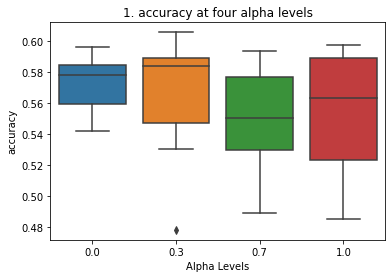

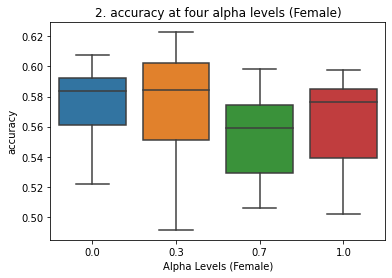

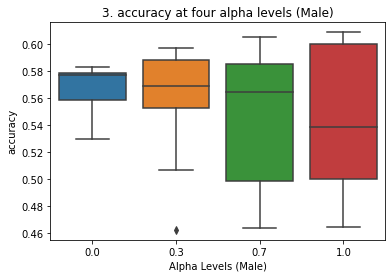

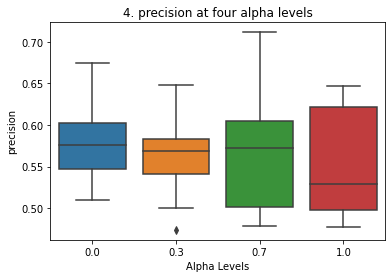

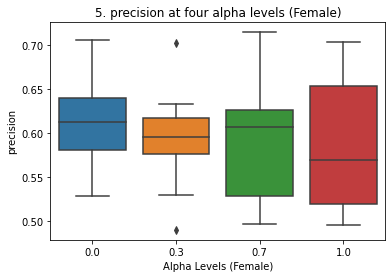

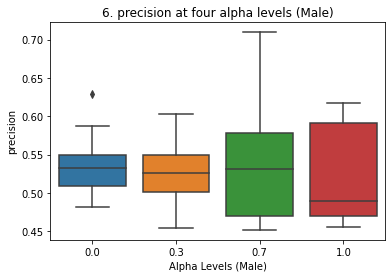

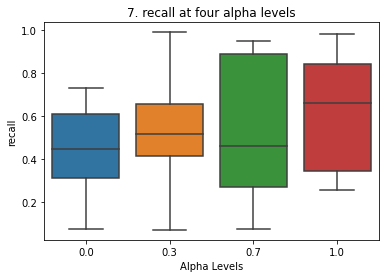

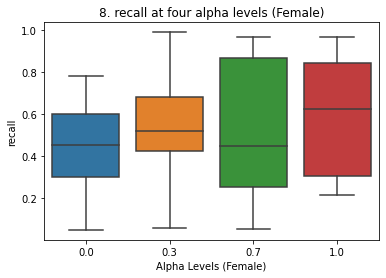

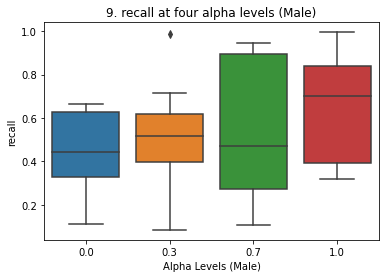

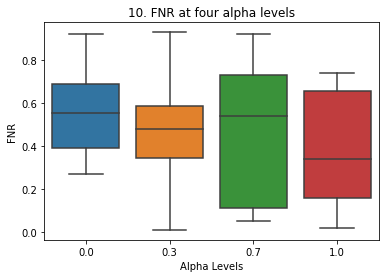

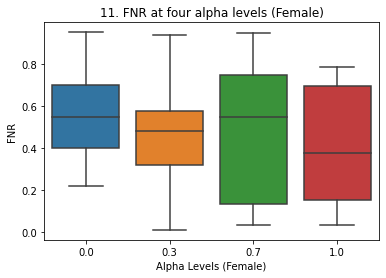

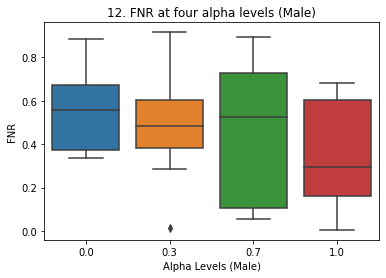

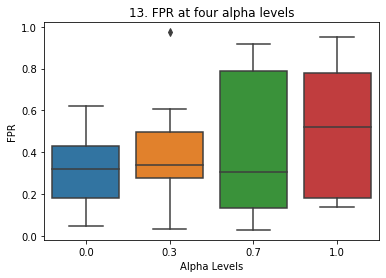

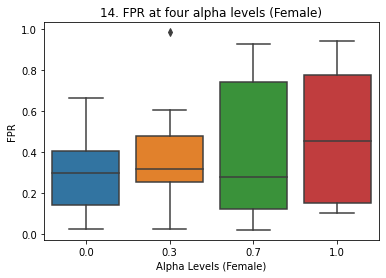

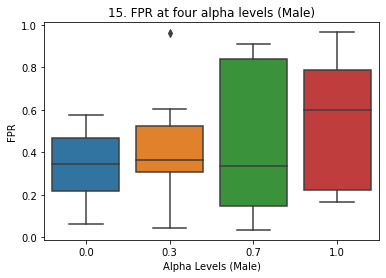

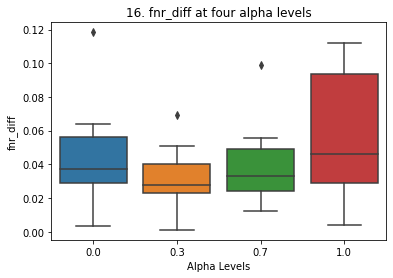

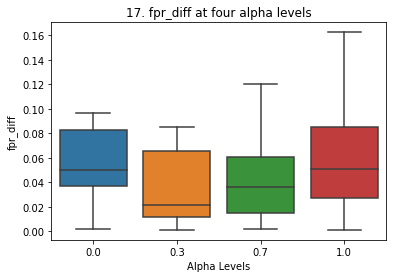

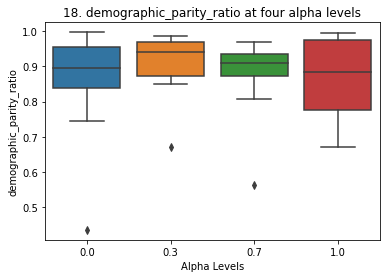

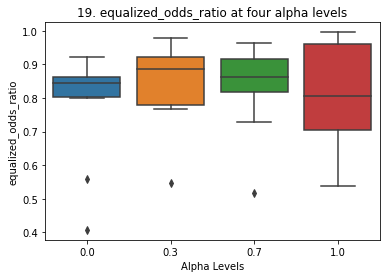

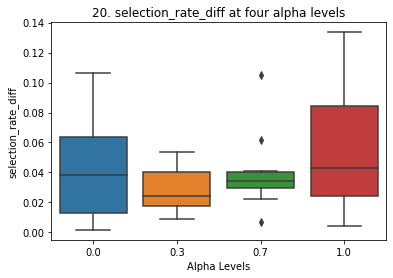

In [76]:
#@markdown ### Plot all our metrics as line plots while varying alpha
var_l =  []

count = 1
for m in ["accuracy","precision","recall","FNR","FPR"]:
  lst = []
  lst_f = []
  lst_m = []

  for k in [0, 0.3, 0.7, 1]:
    for i in range(10):
      v = f'a_{i}_{k}'
      #display(d_t)
      #print(d_t.columns)
      # (dfs_bygroup[v])
      # dfs_overall[v].to_csv(f"{v}_overall.csv")
      # dfs_bygroup[v].to_csv(f"{v}_bygroup.csv")
      lst.append([k, dfs_overall[v].loc[0, m]])
      lst_f.append([k, dfs_bygroup[v].loc['female', m]])
      lst_m.append([k, dfs_bygroup[v].loc['male', m]])


  plot_df = pd.DataFrame(data=lst,columns=["Alphas","val"])
  sns.boxplot(x="Alphas",y="val",data=plot_df)
  plt.title(str(count) +". "+ m + " at four alpha levels")
  plt.xlabel("Alpha Levels")
  plt.ylabel(m)
  plt.show()
  count += 1

  plot_df_f = pd.DataFrame(data=lst_f,columns=["Alphas","val"])
  sns.boxplot(x="Alphas",y="val",data=plot_df_f)
  plt.title(str(count) +". "+ m + " at four alpha levels (Female)")
  plt.xlabel("Alpha Levels (Female)")
  plt.ylabel(m)
  plt.show()
  count += 1

  plot_df_m = pd.DataFrame(data=lst_m,columns=["Alphas","val"])
  sns.boxplot(x="Alphas",y="val",data=plot_df_m)
  plt.title(str(count) + ". "+m + " at four alpha levels (Male)")
  plt.xlabel("Alpha Levels (Male)")
  plt.ylabel(m)
  plt.show()
  count += 1


for m in ['fnr_diff','fpr_diff',
        'demographic_parity_ratio',
        'equalized_odds_ratio',
        'selection_rate_diff']:
  lst = []
  for k in [0, 0.3, 0.7, 1]:
    for i in range(10):
      v = f'a_{i}_{k}'

      lst.append([k, dfs_overall[v].loc[0, m]])

  plot_df = pd.DataFrame(data=lst,columns=["Alphas","val"])
  sns.boxplot(x="Alphas",y="val",data=plot_df)
  plt.title(str(count) +". "+ m + " at four alpha levels")
  plt.xlabel("Alpha Levels")
  plt.ylabel(m)
  plt.show()
  count += 1

### Q4d Answer
When we examine the box plot, we pay particular attention to the data's central tendency as well as its variability. The box that is included in a box plot is a representation of the interquartile range (IQR), which encompasses the data that falls in the middle 50% of the distribution. When the data is arranged in descending order, the value that corresponds to the median is the line that is drawn inside the box. The median is the middle value of the data.

Based on the examination of the box plots, we can see that models with hyperparameters a=0 and a=0.3 have a tendency to have better results in comparison to models with hyperparameters a=0.7 and a=1 for the accuracy and precision measure. This is something that we can observe for ourselves. This pattern is observable across the board, including in both the male and female populations.

In this set of ten measures, the performance associated with a = 1 is often the worst, and the performance associated with a = 0 is typically the second worst. The results for a = 0.3 and a = 0.7 are typically interchangeable with one another. The models that have moderate hyperparameters can be considered as a balanced alternative between the models that have the highest and models that have the lowest hyperparameters; nonetheless, the models with moderate hyperparameters generate higher IQR ranges than the other two on most metrics. 

In most metrics, a = 0.3 has a significant lower variaty than a = 0.7. Thefore It's possible that a = 0.3 is a better value for alpha because it strikes a better balance between fairness and accuracy than a = 0.7. Additionally, a = 0.3 may have resulted in a model that is less sensitive to differences in the data between the male and female groups. This could explain why it has lower variability in the metrics across gender.

The a = 0.3 and 0.7 has a worse accuracy, precision, and FNR when compared to the 4b, but the variance for the FPR rate difference is reduced. While the box plot does provide a summary of the data, it does not provide a deep knowledge of the underlying patterns and relationships in the data. This is an important point to keep in mind as we come to the conclusion of this discussion. As a result of this, it is frequently required to augment the box plot with additional statistical tools and studies in order to have a comprehensive understanding of how well our models work.

# Problem 2, Part (d) 
### **Threshold Optimizer Post-processing intervention**



In [97]:
#@markdown Fit the ThresholdOptimizer model here

df_d_o = {}
df_d_b = {}
for i in range(10):
  X_train, X_test, y_train, y_test = train_test_split(x_numeric, y_raw, 
                                                      test_size=0.2, random_state=random.randint(100,1000))
  model = RandomForestClassifier(n_estimators=1000,max_depth=10).fit(X_train, y_train)
  #
  post_model = ThresholdOptimizer(
        estimator= model,
        constraints='false_negative_rate_parity',
        prefit=True, # If True, avoid refitting the given estimator.
      ).fit(X_train, y_train, sensitive_features=X_train["gender_Female"])


  y_pred = post_model.predict(X_test,sensitive_features=X_test["gender_Female"]) 

  sensitive_f = X_test['gender_Female'].replace({1:'female', 0:'male'})

  temp = MetricFrame(
      metrics= metric_dict,
      y_true=y_test,
      y_pred=y_pred, 
      sensitive_features = sensitive_f,
      sample_params = sample_p
  )
  df_d_o[i] = temp.overall.to_frame().transpose()
  df_d_b[i] = temp.by_group.iloc[:,:5]



/usr/local/lib/python3.9/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(
/usr/local/lib/python3.9/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(
/usr/local/lib/python3.9/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  w

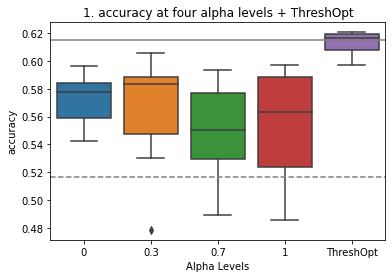

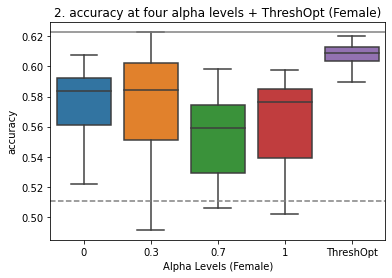

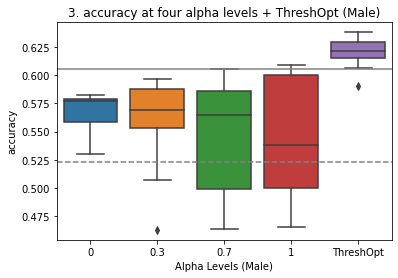

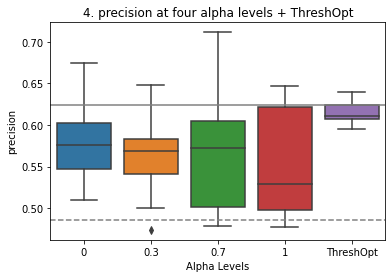

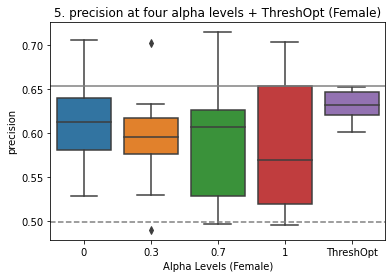

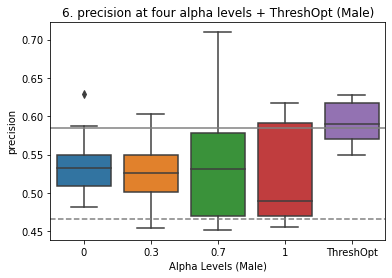

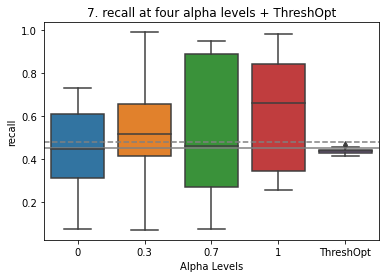

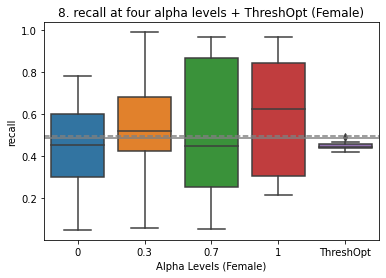

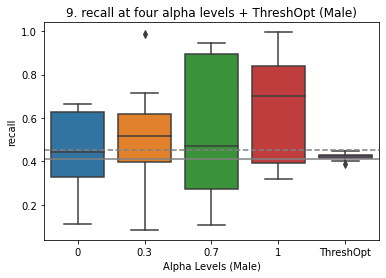

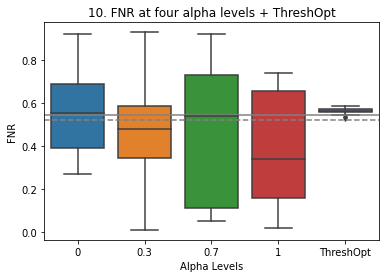

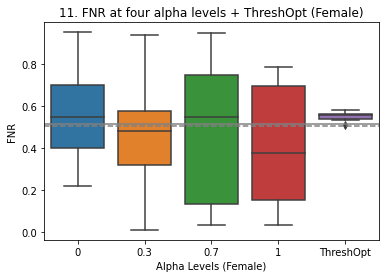

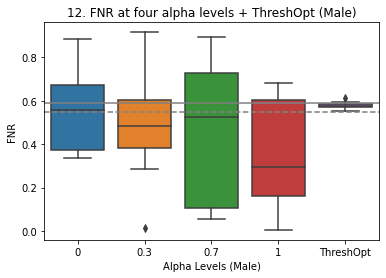

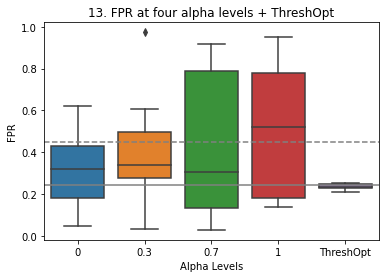

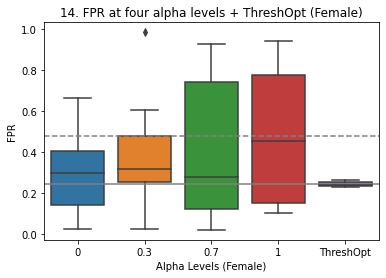

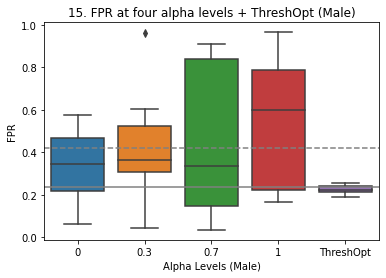

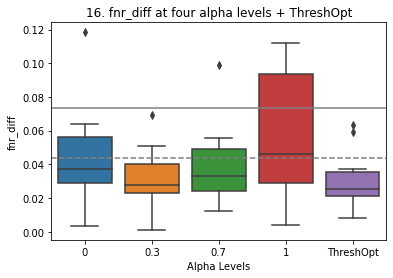

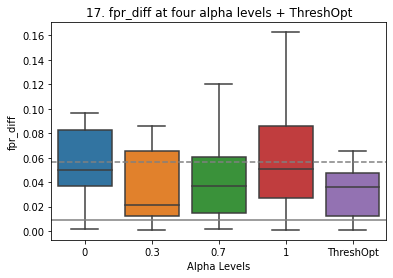

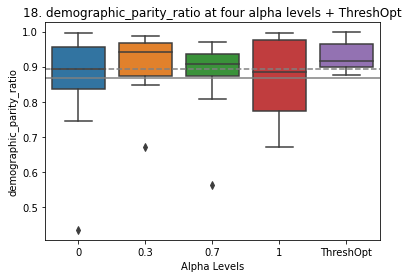

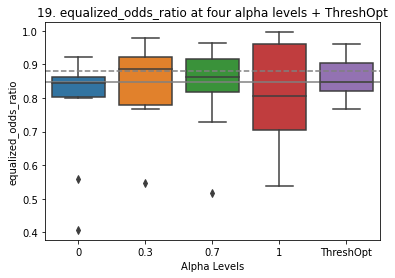

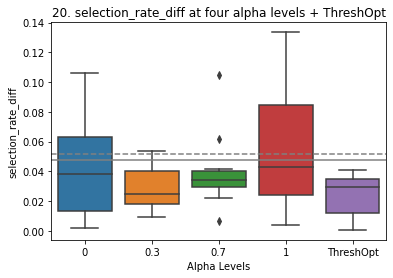

In [99]:
var_l =  []

count = 1
for m in ["accuracy","precision","recall","FNR","FPR"]:
  lst = []
  lst_f = []
  lst_m = []

  for k in [0, 0.3, 0.7, 1, 'ThreshOpt']:
    for i in range(10):
      v = f'a_{i}_{k}'
      #display(d_t)
      #print(d_t.columns)
      # (dfs_bygroup[v])
      # dfs_overall[v].to_csv(f"{v}_overall.csv")
      # dfs_bygroup[v].to_csv(f"{v}_bygroup.csv")
      if type(k) != str:
        lst.append([k, dfs_overall[v].loc[0, m]])
        lst_f.append([k, dfs_bygroup[v].loc['female', m]])
        lst_m.append([k, dfs_bygroup[v].loc['male', m]])
      else:
        lst.append([k, df_d_o[i].loc[0, m]])
        lst_f.append([k, df_d_b[i].loc['female', m]])
        lst_m.append([k, df_d_b[i].loc['male', m]])



  plot_df = pd.DataFrame(data=lst,columns=["Alphas","val"])
  #display(plot_df)
  sns.boxplot(x="Alphas",y="val",data=plot_df)
  plt.title(str(count) +". "+ m + " at four alpha levels + ThreshOpt")
  plt.xlabel("Alpha Levels")
  plt.ylabel(m)
  plt.axhline(y = df_1_o.loc[0, m], color = 'grey', linestyle = '--')
  plt.axhline(y = df_2_o.loc[0, m], color = 'grey')
  plt.show()
  count += 1

  plot_df_f = pd.DataFrame(data=lst_f,columns=["Alphas","val"])
  sns.boxplot(x="Alphas",y="val",data=plot_df_f)
  plt.title(str(count) +". "+ m + " at four alpha levels + ThreshOpt (Female)")
  plt.xlabel("Alpha Levels (Female)")
  plt.ylabel(m)
  plt.axhline(y = df_1_b.loc['female', m], color = 'grey', linestyle = '--')
  plt.axhline(y = df_2_b.loc['female', m], color = 'grey')
  plt.show()
  count += 1

  plot_df_m = pd.DataFrame(data=lst_m,columns=["Alphas","val"])
  sns.boxplot(x="Alphas",y="val",data=plot_df_m)
  plt.title(str(count) + ". "+m + " at four alpha levels + ThreshOpt (Male)")
  plt.xlabel("Alpha Levels (Male)")
  plt.axhline(y = df_1_b.loc['male', m], color = 'grey', linestyle = '--')
  plt.axhline(y = df_2_b.loc['male', m], color = 'grey')
  plt.ylabel(m)
  plt.show()
  count += 1


for m in ['fnr_diff','fpr_diff',
        'demographic_parity_ratio',
        'equalized_odds_ratio',
        'selection_rate_diff']:
  lst = []
  for k in [0, 0.3, 0.7, 1, 'ThreshOpt']:
    for i in range(10):
      v = f'a_{i}_{k}'
      if type(k) != str:
        lst.append([k, dfs_overall[v].loc[0, m]])
      else:
        lst.append([k, df_d_o[i].loc[0, m]])
  plot_df = pd.DataFrame(data=lst,columns=["Alphas","val"])
  sns.boxplot(x="Alphas",y="val",data=plot_df)
  plt.title(str(count) +". "+ m + " at four alpha levels + ThreshOpt")
  plt.xlabel("Alpha Levels")
  plt.ylabel(m)
  plt.axhline(y = df_1_o.loc[0, m], color = 'grey', linestyle = '--')
  plt.axhline(y = df_2_o.loc[0, m], color = 'grey')
  plt.show()
  count += 1



### Q4d Answer
Models of ThreOpt and the random forest generally outperform models of simple neural network and the Adversarial Fairness, with respect to accuracy, precision, recall, and FPR metrics and in most of the cases, Adversarial Fairness with a proper alpha level, has better fairness over genders. 

ThresholdOptimizer can further improve the performance of Random Forest by optimizing the threshold values for each protected group, which can lead to a better balance between the true positive and false positive rates. This can be seen in our box plots where the median values of the FPR difference across genders were lower for ThresholdOptimizer as compared to Adversarial Fairness. However, when it comes to fairness considerations, Adversarial Fairness with a proper alpha level seemed to perform better than the other models. This is because Adversarial Fairness has a built-in mechanism that tries to equalize the false positive rates across protected groups by minimizing a loss function that penalizes the classifier for predicting differently for similar inputs from different groups.

We observed a clear trade-off between model accuracy and fairness throughout the experiment. We discovered that the more we optimize for fairness, the lower the model's accuracy becomes. When we optimize for accuracy, we see a decrease in fairness, particularly in the FPR and FNR metrics.

The ThresholdOptimizer and random forest fairness interventions outperformed the simple neural network and Adversarial Fairness methods in general. The ThresholdOptimizer in particular demonstrated a more balanced performance across fairness metrics and accuracy, especially when the alpha level was set to 0.3. However, when we set the alpha level to the appropriate level, Adversarial Fairness performed better in terms of fairness.

We observed some variations in the impact of gender on model performance. In most metrics, the female gender's performance was slightly lower than the male gender's, particularly in terms of recall and FNR. When we optimized for fairness, the models' performance for both genders was comparable.

Overall, these findings suggest that fairness and accuracy are not mutually exclusive, and that there is always a trade-off between the two. As a result, when developing machine learning models, it is critical to carefully consider the balance between fairness and accuracy, especially in applications where fairness is critical.